<a href="https://colab.research.google.com/github/rcgonzsv/pneumonia_detection/blob/master/Build_and_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
from random import sample 
import scipy
import sklearn.metrics
import sklearn.model_selection as skl
from sklearn.utils import class_weight

import tensorflow as tf
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, MaxPooling2D, Reshape
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet_v2 import ResNet50V2 
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, TensorBoard, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [0]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
45689,00011702_063.png,Effusion|Infiltration,63,11702,26,F,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00011702_063.png
70952,00017504_030.png,No Finding,30,17504,12,F,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00017504_030.png
14510,00003770_011.png,No Finding,11,3770,57,M,PA,2992,2991,0.143,0.143,NaN,/data/images_002/images/00003770_011.png


In [0]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [0]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia']
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
109857,00029881_002.png,Effusion|Infiltration|Nodule,2,29881,52,M,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54877,00013741_000.png,Cardiomegaly|Infiltration,0,13741,79,F,PA,2992,2991,0.143000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78754,00019327_000.png,Atelectasis,0,19327,48,M,PA,2730,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Create your training and testing data:

In [0]:
def create_splits(df, test_size, column_name):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_data, valid_data = skl.train_test_split(df, 
                                   test_size = test_size, 
                                   stratify = df[column_name])
    ## making equal proportions of Pneumonia in both sets!
    # traing data
    p_inds = train_data[train_data[column_name] == 1].index.tolist()
    np_inds = train_data[train_data[column_name] ==0].index.tolist()
    
    np_sample = sample(np_inds,len(p_inds))
    train_data = train_data.loc[p_inds + np_sample]
    
    # validation data
    p_inds = valid_data[valid_data[column_name]==1].index.tolist()
    np_inds = valid_data[valid_data[column_name]==0].index.tolist()

    np_sample = sample(np_inds,4*len(p_inds))
    valid_data = valid_data.loc[p_inds + np_sample]
    return train_data, valid_data
train_data, valid_data = create_splits(all_xray_df, 0.2, 'pneumonia_class')

In [0]:
train_data['pneumonia_class'].sum()/len(train_data)

0.5

In [0]:
valid_data['pneumonia_class'].sum()/len(valid_data)

0.2

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [0]:
def my_image_augmentation():
    

    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              rotation_range=40, 
                              shear_range = 0.2,
                              zoom_range=0.2)
    return my_idg


def make_train_gen(train_data, img_size, batch_size):
    

    
    idg = my_image_augmentation()        
    train_gen = idg.flow_from_dataframe(dataframe=train_data, 
                                             directory=None, 
                                             x_col = "path",
                                             y_col = "pneumonia_class",
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = batch_size)
                                             
    return train_gen


def make_val_gen(valid_data, img_size, batch_size):
    

    val_idg = ImageDataGenerator(rescale=1./255.)
    val_gen = val_idg.flow_from_dataframe(dataframe = valid_data, 
                                             directory=None, 
                                             x_col = "path",
                                             y_col = "pneumonia_class",
                                             class_mode = 'raw',
                                             target_size = img_size, 
                                             batch_size = val_batch_size) 
    return val_gen

batch_size = 16
val_batch_size = 1000
img_size = (224, 224)

train_gen = make_train_gen(train_data, img_size, batch_size)
val_gen = make_val_gen(valid_data, img_size, batch_size)

Found 2290 validated image filenames.
Found 1430 validated image filenames.


In [0]:
## Pulling a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

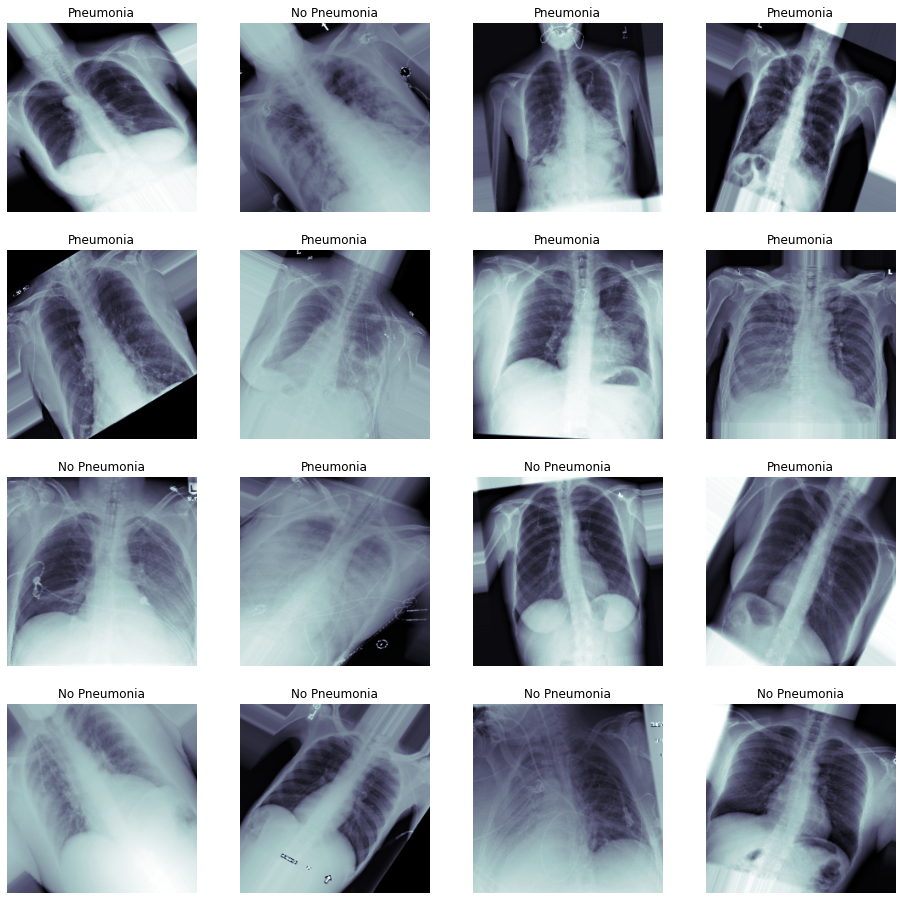

In [0]:
## Visualization of some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [0]:
def load_pretrained_model():
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
    
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model


In [0]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model = Sequential()
    
    vgg_model = load_pretrained_model()
    
    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.3))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(512, activation='relu'))

    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.3))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    #my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model

my_model = build_my_model()
my_model.summary()

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

553467904/553467096 [==============================] - 7s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_____________________________________________________

In [0]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_binary_accuracy", 
                      mode= "auto", 
                      patience=10)

def scheduler(epoch, lr):
    if epoch < 1:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
#callbacks_list = [checkpoint, early]
callbacks_list = [checkpoint, early, lr_scheduler]

In [0]:
from keras.models import model_from_json
model_path = 'my_model.json' #path to saved model
weight_path = 'xray_class_my_model.best.hdf5' #path to saved best weights

json_file = open(model_path, "r")
loaded_model_json = json_file.read()
json_file.close()
my_model = model_from_json(loaded_model_json)
my_model.load_weights(weight_path)

### Start training! 

In [0]:
## train your model

#optimizer = RMSprop(learning_rate=1e-5)
optimizer = Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY),
                          epochs = 20, 
                          callbacks = callbacks_list)

Epoch 1/20
144/144 [==============================] - 75s 519ms/step - loss: 0.6935 - binary_accuracy: 0.4987 - val_loss: 0.6792 - val_binary_accuracy: 0.7890

Epoch 00001: val_binary_accuracy improved from -inf to 0.78900, saving model to xray_class_my_model.best.hdf5
Epoch 2/20
144/144 [==============================] - 63s 441ms/step - loss: 0.6934 - binary_accuracy: 0.5100 - val_loss: 0.6884 - val_binary_accuracy: 0.7890

Epoch 00002: val_binary_accuracy did not improve from 0.78900
Epoch 3/20
144/144 [==============================] - 64s 445ms/step - loss: 0.6933 - binary_accuracy: 0.5083 - val_loss: 0.6871 - val_binary_accuracy: 0.7890

Epoch 00003: val_binary_accuracy did not improve from 0.78900
Epoch 4/20
144/144 [==============================] - 64s 442ms/step - loss: 0.6935 - binary_accuracy: 0.4930 - val_loss: 0.6897 - val_binary_accuracy: 0.7910

Epoch 00004: val_binary_accuracy improved from 0.78900 to 0.79100, saving model to xray_class_my_model.best.hdf5
Epoch 5/20
14

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [0]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 64, verbose = True)

1000/1000 [==============================] - 21s 21ms/step


In [0]:
def plot_auc(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    plt.title('AUC ROC Curve')
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.title('Precision Recall Curve')
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def plot_prec_recall_vs_tresh(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.title('F1 Score vs Threshold')
    plt.plot(thresholds, precision[:-1], 'b--', label='precision')
    plt.plot(thresholds, recall[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='upper left')
    plt.ylim([0,1])

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)


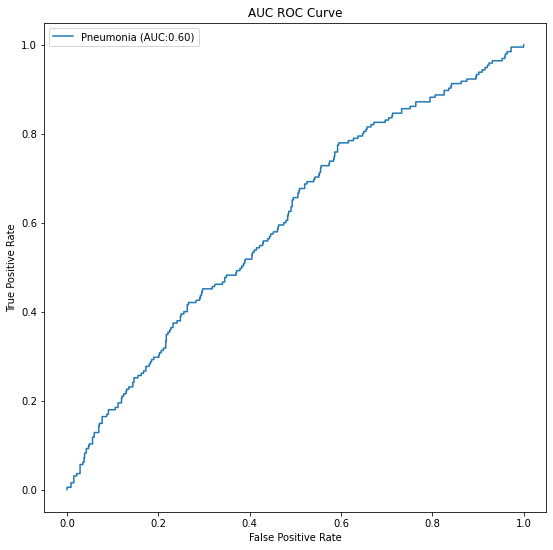

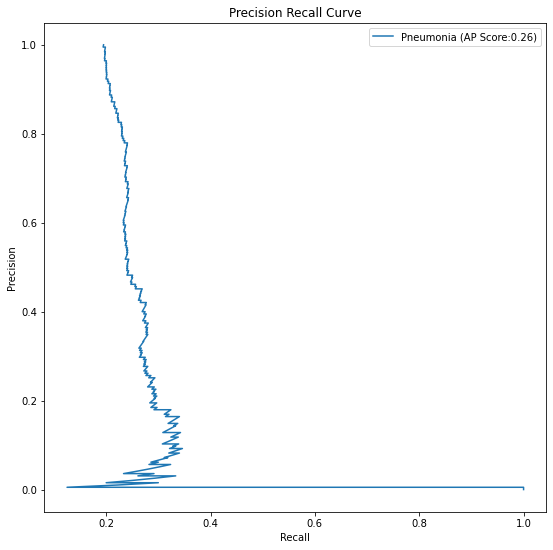

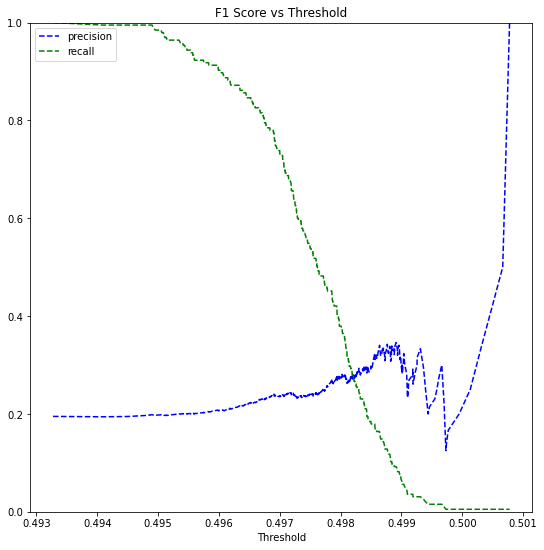

In [0]:
## plot figures

plot_auc(valY, pred_Y)
plot_pr(valY, pred_Y)
plot_prec_recall_vs_tresh(valY, pred_Y)
#plot_history(history)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [0]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def optimize_accuracy(t_y, p_y):
    best_threshold = None
    best_accuracy = 0.
    for t in np.arange(0.5,1,0.001):
        pred = (p_y.reshape(-1)>t)*1.
        accuracy = np.mean(pred==t_y)
        if accuracy > best_accuracy:
            best_threshold = t
            best_accuracy = accuracy
    return best_threshold, best_accuracy

best_threshold, best_accuracy = optimize_accuracy(valY, pred_Y)
print("Threshold of %.2f gives best accuracy at %.4f"%(best_threshold, best_accuracy))

pred_Y_class = pred_Y > best_threshold
f1_score(valY, pred_Y_class)

Threshold of 0.50 gives best accuracy at 0.7910


0.018779342723004695

In [0]:
precision, recall, thresholds = precision_recall_curve(valY, pred_Y)

In [0]:
# Look at the threshold where precision is 0.8
precision_value = 0.8
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.6666666666666666
Recall is: 0.009478672985781991
Threshold is: 0.4999783
F1 Score is: 0.01869158878504673


In [0]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

Precision is: 0.24421965317919075
Recall is: 0.8009478672985783
Threshold is: 0.49668416
F1 Score is: 0.3743078626799557


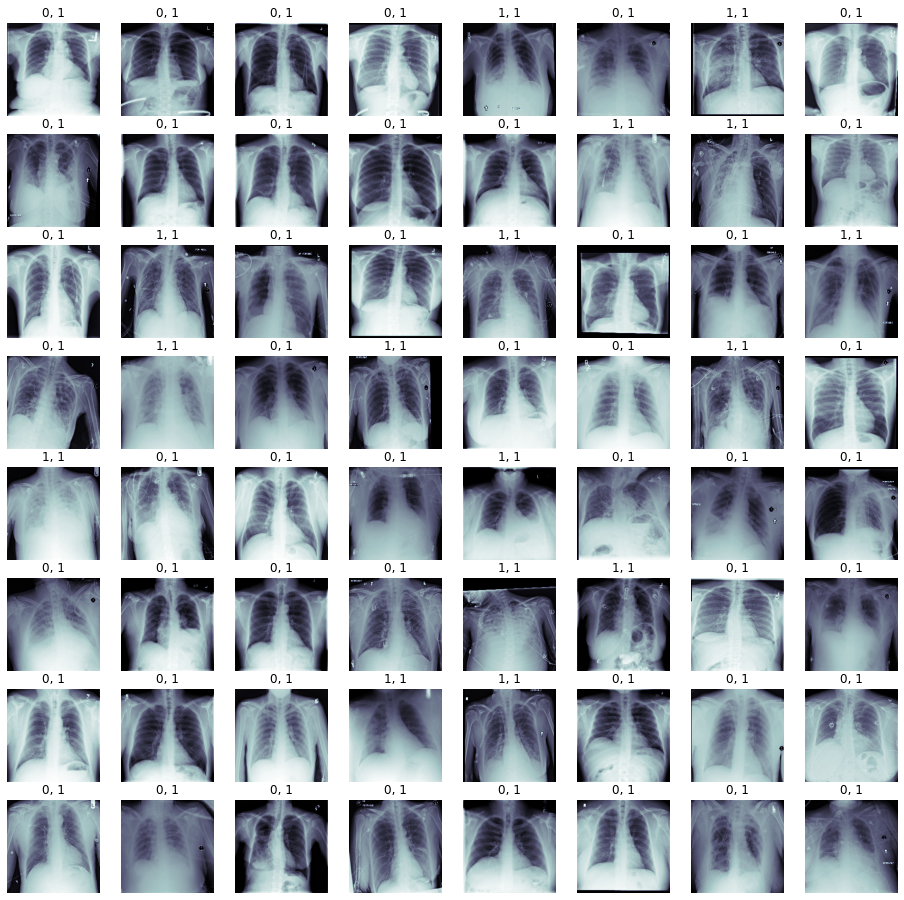

In [0]:
## Let's look at some examples of predicted v. true with our best model: 

# Todo
YOUR_THRESHOLD = 0.49
fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [0]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)